# Downloading and Combining Datasets (Part 1/4)
**Download** | Structure | Preprocess | Train

<pre>
</pre>

In this notebook, you will use a dataset manifest to download animal images from the COCO dataset for all ten animal classes. You will then download frog images from the CIFAR dataset and add them to your COCO animal images. In order to simulate coming to SageMaker with your own dataset, we will keep the data in an unstructured form until the next notebook where you will learn the best practices for structuring an image dataset.

## Overview
* #### The COCO and CIFAR datasets
* #### Download the annotations
* #### Extract animal annotations
* #### Sample the dataset
* #### Combine with CIFAR-10 frog data
* #### Store annotations for next guides

<pre>
</pre>

In [24]:
import json
import pickle
import shutil
import urllib
import pathlib
import tarfile
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from imageio import imread, imwrite
from joblib import Parallel, delayed, parallel_backend

<pre>
</pre>

## The COCO and CIFAR Datasets
___
For this series of notebooks we will be sampling images from the [COCO dataset](https://cocodataset.org) and [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) (before beginning the notebooks in this series, it's a good idea to browse each dataset website to familiaraize youreself with the data). Both are datasets of images, but come formatted very differently. The COCO dataset contains images from Flickr that represent a real-world dataset which isn't formatted or resized specifically for deep learning. This makes it a good dataset for this guide because we want it to be as comprehensive as possible. The CIFAR-10 images, on the other hand, are preprocessed specifically for deep learning as they come cropped, resized and vectorized (i.e. not in a readable image format). This notebooks will show you how to work with both types of datasets.

<pre>
</pre>

## Download the Annotations
____
The dataset annotation file contains info on each image in the dataset such as the class, superclass, file name and url to download the file. Just the annotations for the COCO dataset are about 242MB.

In [6]:
anno_url = 'http://images.cocodataset.org/annotations/annotations_trainval2017.zip'
urllib.request.urlretrieve(anno_url, "coco-annotations.zip");

In [7]:
shutil.unpack_archive('coco-annotations.zip')

#### Load the annotations into Python
The training and validation annotations come in separate files

In [8]:
with open('annotations/instances_train2017.json', 'r') as f:
    train_metadata = json.load(f)

with open('annotations/instances_val2017.json', 'r') as f:
    val_metadata = json.load(f)

<pre>
</pre>

## Extract Just the Animal Annotations
___
To limit the scope of the dataset for this guide we're only using the images of animals in the COCO dataset

In [9]:
category_labels = {c['id']: c['name'] for c in train_metadata['categories'] if c['supercategory'] == 'animal'}

In [10]:
train_annos = {}
for a in train_metadata['annotations']:
    if a['category_id'] in category_labels:
        train_annos[ a['image_id'] ] = {'category_id': a['category_id']}

train_images = {}
for i in train_metadata['images']:
    train_images[ i['id'] ] = {'coco_url': i['coco_url'], 'file_name': i['file_name']}
    
val_annos = {}
for a in val_metadata['annotations']:
    if a['category_id'] in category_labels:
        val_annos[ a['image_id'] ] = {'category_id': a['category_id']}

val_images = {}
for i in val_metadata['images']:
    val_images[ i['id'] ] = {'coco_url': i['coco_url'], 'file_name': i['file_name']}

We'll need to combine some of the image info with the class info for each record

In [11]:
for id, anno in train_annos.items():
    anno.update(train_images[id])
    
for id, anno in val_annos.items():
    anno.update(val_images[id])

Later in this series of guides we'll make our own train, validation and test splits. For this reason we'll combine the training and validation datasets together

In [12]:
all_annos = {}
for k, v in train_annos.items():
    all_annos.update({k: v})
for k, v in val_annos.items():
    all_annos.update({k: v})

<pre>
</pre>

## Sample the Dataset
___
In order to make working with the data easier, we'll select 250 images from each class at random. To make sure you get the same set of cell images for each run of this we'll also set Numpy's random seed to 0. This is a small fraction of the dataset, but it demonstrates how using transfer learning can give you good results without needing very large datasets.

In [13]:
np.random.seed(0)

In [14]:
sample_annos = {}

for category_id in category_labels:
    subset = [k for k, v in all_annos.items() if v['category_id'] == category_id]
    sample = np.random.choice(subset, size=250, replace=False)
    for k in sample:
        sample_annos[k] = all_annos[k]

#### Create a download function
In order to parallelize downloading the images we must wrap the download and save process with a function for multi-threading with joblib.

In [15]:
def download_image(url, path):
    data = imread(url)
    imwrite(path / url.split('/')[-1], data)

#### Download the sample of the dataset (2,500 images, ~5min)

In [16]:
sample_dir = pathlib.Path('data_sample_2500')
sample_dir.mkdir(exist_ok=True)

In [ ]:
with parallel_backend('threading', n_jobs=5):
    Parallel(verbose=3)(delayed(download_image)(a['coco_url'], sample_dir) for a in sample_annos.values())

<pre>
</pre>

## Combine with CIFAR-10 Frog Data
The COCO dataset doesn't include any images of frogs, but let's say our model must also be able to label images of frogs. To fix this we can download another dataset of images which includes frogs, sample 250 frog images and add them to our existing image data. These images are much smaller (32x32) so they will appear pixelated and blurry when we increase the size of them to (244x244). We'll use the CIFAR-10 dataset to achieve this. As you'll see the CIFAR-10 dataset comes formatted in a very different manner from COCO dataset. We must process the CIFAR-10 data into individual image files so that it's congruent to our COCO images.
___

### Download and Extract the CIFAR-10 Dataset

In [ ]:
!wget https://www.cs.toronto.edu/%7Ekriz/cifar-10-python.tar.gz

In [19]:
tf = tarfile.open('cifar-10-python.tar.gz')
tf.extractall()

### Open First Batch of CIFAR-10 Dataset
The CIFAR-10 dataset comes in five training batches and one test batch. Each training batch has 10,000 randomly ordered images. Since we only need 250 frog images for our dataset, just pulling from the first batch will suffice.

In [20]:
with open('./cifar-10-batches-py/data_batch_1', 'rb') as f:
    batch_1 = pickle.load(f, encoding='bytes')

In [21]:
image_data = batch_1[b'data']

### Pull 250 Sample Frog Images

In [22]:
frog_indices = np.array(batch_1[b'labels']) == 6
sample_frog_indices = np.random.choice(frog_indices.nonzero()[0], size=250, replace=False)
sample_data = image_data[sample_frog_indices, :]
frog_images = sample_data.reshape(len(sample_data), 3, 32, 32).transpose(0, 2, 3, 1)

### View Frog Images

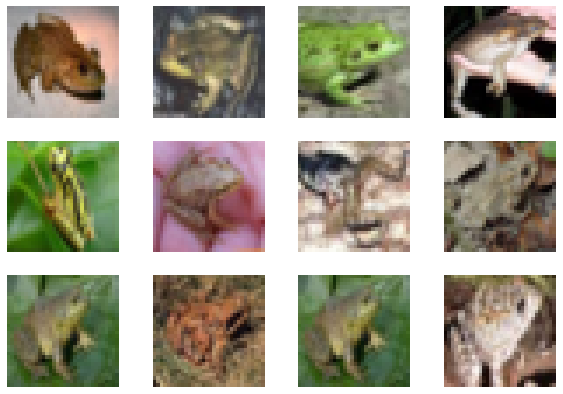

In [25]:
fig, axs = plt.subplots(3, 4, figsize=(10, 7))
indices = np.random.randint(low=0, high=249, size=12)

for i, ax in enumerate(axs.flatten()):
    ax.imshow(frog_images[indices[i]])
    ax.axis('off')

### Write Sample Frog Images to `data_sample_2500` Directory

In [26]:
frog_filenames = np.array(batch_1[b'filenames'])[sample_frog_indices]

In [28]:
for idx, filename in enumerate(frog_filenames):
    filename = filename.decode()
    data = frog_images[idx]
    if filename.endswith('.png'):
        filename = filename.replace('.png', '.jpg')
    imwrite(sample_dir/filename, data)

In [29]:
sample_dir.rename('data_sample_2750')

### Add Frog Annotations to `sample_annos`

In [30]:
category_labels[26] = 'frog'

In [31]:
next_anno_idx = np.array(list(sample_annos.keys())).max() + 1

frog_anno_ids = range(next_anno_idx, next_anno_idx + len(frog_images))

In [35]:
for idx, frog_id in enumerate(frog_anno_ids):
    sample_annos[frog_id] = {'category_id': 26, 'file_name': frog_filenames[idx].decode().replace('.png', '.jpg')}

<pre>
</pre>

## Store Annotations for Next Guides
___
This is just the first in a series of guides for training a deep learning model with image data. In order to make sure your work carries over to subsequent notebooks, you will create a folder called `pickled_data` which will store your dataset annotations and asset names.

In [36]:
pickled_dir = pathlib.Path('./pickled_data')
pickled_dir.mkdir(exist_ok=True)

with open('pickled_data/sample_annos.pickle', 'wb') as f:
    pickle.dump(sample_annos, f)
    
with open('./pickled_data/category_labels.pickle', 'wb') as f:
    pickle.dump(category_labels, f)